In [1]:
# standard libraries
import pandas as pd
import numpy as np
import time

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras

# scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import optuna

pd.set_option('display.max_columns', None)

# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

2023-10-07 16:45:04.222603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [6]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [8]:
target = train.columns.to_list()[-1]
# convert target from bool to int
train[target] = train[target].astype(int)
train_target = train[target]

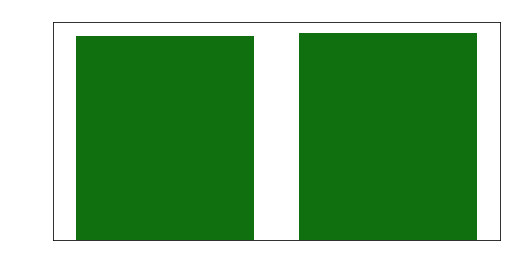

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(data = train, x = target, color='g')
plt.title('Class distribution')
plt.show()

In [10]:
train.drop(target, axis=1, inplace=True)
train_id = train['PassengerId']
test_id = test['PassengerId']

In [11]:
# combine over rows, keeping id for now as group number might be useful
combined = pd.concat([train, test], axis = 0)

### Feature engineering

In [12]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.4+ MB


In [13]:
combined.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [14]:
combined['Group'] = combined['PassengerId'].str[:4]
combined.drop('PassengerId', inplace=True, axis=1)

Categorical columns

In [15]:
# categorical columns
col_cat_NA = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# fill with Group first
for col in col_cat_NA:
    combined[col] = combined.groupby('Group')[col].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
# need to do this, so we can use homeplanet to fill values for destination
combined['HomePlanet'].fillna('', inplace=True)
combined['Destination'] = combined.groupby('HomePlanet')['Destination'].transform(
    lambda x: x.fillna(x.mode()[0]))
# reverse what we did earlier
combined['HomePlanet'].replace('', np.nan, inplace=True)

# now fill homeplanet with destination
combined['HomePlanet'] = combined.groupby('Destination')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0]))

combined['CryoSleep'] = combined.groupby('Destination')['CryoSleep'].transform(
    lambda x: x.fillna(x.mode()[0]))
combined['VIP'].fillna(False, inplace=True)
    
# need to break cabin down, this is screwing it up when the entire cabin isn't available
combined[['deck', 'cabin_num', 'side']] = combined['Cabin'].str.split('/', expand=True)

combined.drop('Cabin', inplace=True, axis=1)

col_cat_na = ['deck', 'cabin_num', 'side']

for col in col_cat_na:
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.mode()[0]))
combined['cabin_num'] = combined['cabin_num'].astype(int)

# drop name
combined.drop('Name', inplace=True, axis=1)

Numerical columns

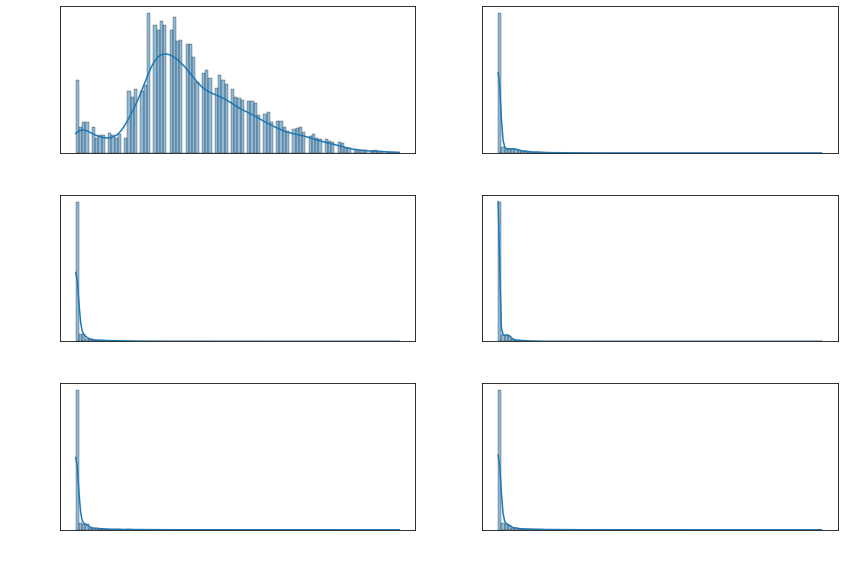

In [16]:
# numerical columns 
col_num = combined.select_dtypes(include=['number']).columns
col_num = col_num.drop(['cabin_num', 'CryoSleep'])

# subplot placehodlers
fig, axes = plt.subplots(3, 2, figsize=(12,8))

# flatten the axes for easier indexing
axes = axes.ravel()

# iterate over number columns, enumerate cause working with index list
for i, col in enumerate(col_num):
    ax = axes[i]
    # checking distribution for data above 0
    t = combined.loc[combined[col]>-1]
    sns.histplot(t[col], ax=ax, kde=True, bins=100)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    
# adjust layout
plt.tight_layout()

plt.show()

In [17]:
display(combined.loc[combined['RoomService']>0].describe())
display(combined.loc[combined['RoomService']>0].median())

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num
count,4404.000000,4321.000000,4404.000000,4296.000000,4303.000000,4304.000000,4322.000000,4404.000000
mean,0.004087,31.032631,643.134196,484.818203,313.019986,365.609433,337.559695,645.533606
std,0.063808,12.431650,969.486624,1477.621759,657.312688,1118.498526,1187.149866,536.059777
min,0.000000,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,37.000000,0.000000,0.000000,0.000000,0.000000,193.000000
50%,0.000000,28.000000,313.500000,2.000000,19.000000,6.000000,1.000000,471.000000
75%,0.000000,38.000000,857.000000,276.000000,372.000000,245.000000,171.000000,1070.250000
max,1.000000,79.000000,14327.000000,26830.000000,8098.000000,22408.000000,24133.000000,1894.000000


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_54379/3600371989.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(combined.loc[combined['RoomService']>0].median())


CryoSleep          0.0
Age               28.0
VIP                0.0
RoomService      313.5
FoodCourt          2.0
ShoppingMall      19.0
Spa                6.0
VRDeck             1.0
Group           4639.5
cabin_num        471.0
dtype: float64

In [18]:
# replace 0s with null
# combined[col_num] = combined[col_num].replace(0, np.nan)

# fill with Group first
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Group')[col].transform(
        lambda x: x.fillna(x.mean()))

In [19]:
# fill with destination now
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.median()))

In [20]:
# take log due to skewed distribution
for i, col in enumerate(col_num):
    combined[col] = np.log1p(combined[col])

In [21]:
# adding new features
combined['TotalSpent'] = combined[['RoomService', 'FoodCourt', 
                                   'ShoppingMall','Spa', 'VRDeck']].sum(axis=1)

# since the distribution is so skewed to 0s, this might help
# combined['moneySpent'] = (combined['TotalSpent']>0).astype(int)

In [22]:
combined['VIP'].unique()

array([0.0, 1.0], dtype=object)

<Figure size 864x576 with 0 Axes>

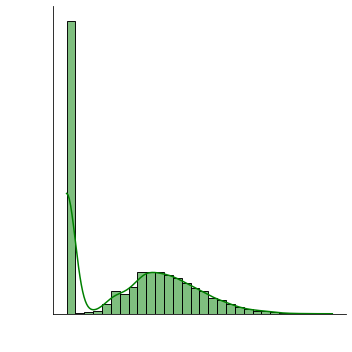

In [23]:
col = 'TotalSpent'
plt.figure(figsize=(12,8))
sns.displot(data=combined, x=col, color='g', kde=True)
plt.show()

In [24]:
col_bool = ['CryoSleep', 'VIP']

# correct dtypes of boolean columns from object to bool then to int
for col in col_bool:
    combined[col] = combined[col].astype(bool).astype(int)

In [25]:
# convert category columns to numerical/binary
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int64  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Group         12970 non-null  object 
 11  deck          12970 non-null  object 
 12  cabin_num     12970 non-null  int64  
 13  side          12970 non-null  object 
 14  TotalSpent    12970 non-null  float64
dtypes: float64(7), int64(3), object(5)
memory usage: 1.6+ MB


In [26]:
# one hot encoding
combined = pd.get_dummies(combined, columns=['HomePlanet', 'Destination', 'deck', 'side'])

# shouldn't be, but for now, let's...maybe this does make sense after all
combined['Group'] = combined['Group'].astype('int')

In [27]:
# change dtypes to int
combined.iloc[:, -16:] = combined.iloc[:, -16:].astype(int)

In [28]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  12970 non-null  int64  
 1   Age                        12970 non-null  float64
 2   VIP                        12970 non-null  int64  
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   Group                      12970 non-null  int64  
 9   cabin_num                  12970 non-null  int64  
 10  TotalSpent                 12970 non-null  float64
 11  HomePlanet_Earth           12970 non-null  int64  
 12  HomePlanet_Europa          12970 non-null  int64  
 13  HomePlanet_Mars            12970 non-null  int6

In [29]:
# saving a combined copy
combinedCopy = combined.copy(deep=True)

In [30]:
combined = combinedCopy.copy(deep=True)

Min-max Normalization

In [31]:
def min_max_norm(col):
    min_val = col.min()
    max_val = col.max()
    
    return (col-min_val) / (max_val - min_val)

combined = combined.apply(min_max_norm)

### Model design

In [32]:
train = combined.iloc[:train_id.shape[0]]
test = combined.iloc[-test_id.shape[0]:]
train[target] = train_target
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (8693, 28)
Test shape (4277, 27)


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_54379/2658725243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target] = train_target


In [33]:
# let's split train data into train/test
def train_test_split(data, test_ratio=0.3):
    test_indices = np.random.rand(data.shape[0]) < test_ratio
    return data[~test_indices], data[test_indices]
train_data, test_data = train_test_split(train)
print('{} samples in training, {} samples in testing data'.format(train_data.shape[0], 
                                                            test_data.shape[0]))

6101 samples in training, 2592 samples in testing data


In [34]:
train_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,cabin_num,TotalSpent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,Transported
3,0.0,0.804733,0.0,0.000000,0.694741,0.588099,0.809679,0.522016,0.000216,0.000000,0.665997,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.0,0.646553,0.0,0.597392,0.413743,0.499171,0.632770,0.108866,0.000323,0.000528,0.564936,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
5,0.0,0.868699,0.0,0.000000,0.600043,0.000000,0.566700,0.000000,0.000431,0.000000,0.298540,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
6,0.0,0.752126,0.0,0.393021,0.712387,0.137742,0.000000,0.000000,0.000539,0.001056,0.314355,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
7,1.0,0.768433,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000539,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8686,0.0,0.797920,0.0,0.072429,0.683790,0.000000,0.392507,0.352315,0.999461,0.051214,0.383287,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8688,0.0,0.852955,1.0,0.000000,0.856823,0.000000,0.739216,0.427839,0.999569,0.051742,0.517336,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8689,1.0,0.671935,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.999784,0.791447,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
8690,0.0,0.752126,0.0,0.000000,0.000000,0.748704,0.069196,0.000000,0.999892,0.791975,0.207147,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6101 entries, 3 to 8691
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  6101 non-null   float64
 1   Age                        6101 non-null   float64
 2   VIP                        6101 non-null   float64
 3   RoomService                6101 non-null   float64
 4   FoodCourt                  6101 non-null   float64
 5   ShoppingMall               6101 non-null   float64
 6   Spa                        6101 non-null   float64
 7   VRDeck                     6101 non-null   float64
 8   Group                      6101 non-null   float64
 9   cabin_num                  6101 non-null   float64
 10  TotalSpent                 6101 non-null   float64
 11  HomePlanet_Earth           6101 non-null   float64
 12  HomePlanet_Europa          6101 non-null   float64
 13  HomePlanet_Mars            6101 non-null   float

Model: Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_data.iloc[:, :-1], train_data[target])

In [ ]:
prediction = lr.predict(test_data.iloc[:, :-1])

In [ ]:
accuracy = accuracy_score(test_data[target], prediction)
print('Accuracy of {}'.format(accuracy))

Model: SVM (takes a while to run this though)

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10], # regularization parameter
#     'kernel': ['linear', 'rbf'], # kernel type
#     'gamma': [0.1, 1, 10] # kernel coefficient
# }

# svm = SVC()
# grid_search = GridSearchCV(svm, param_grid, cv=5)
# grid_search.fit(train_data.iloc[:, :-1], train_data[target])

# grid_search.best_params_

Model: TFDF

In [ ]:
# convert these to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=target)

In [ ]:
rf = tfdf.keras.RandomForestModel()
rf.fit(train_data)

In [ ]:
rf.summary()

In [ ]:
rf.compile(metrics=['accuracy'])
evaluation = rf.evaluate(test_data, return_dict=True)
display(evaluation)

In [ ]:
# tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

Prediction

In [ ]:
test = tfdf.keras.pd_dataframe_to_tf_dataset(test)
predictions = rf.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] >= 0.5)

In [ ]:
output.info()

In [ ]:
output.to_csv('data/sample_submission.csv', index=False)

Model : FNN  
Feedforwrad Neural Network

Parameters to optimize 
- layer size
- neuron size
- layer activation? skip this for now
- output activation? skip this for now
- epoch size
- batch size
- learn rate

In [43]:
def fnn_model(layer_size, neuron_size, epoch_size, batch_size, 
              layer_activation, output_activation, 
              feature_size, target_class_count,
              train_data, target, test_data, learn_rate):
    model = keras.Sequential([
        keras.layers.Dense(layer_size, activation=layer_activation, 
                           input_shape=(feature_size,)),
        keras.layers.Dense(neuron_size, activation=layer_activation),
        keras.layers.Dense(target_class_count, activation=output_activation)
    ])

    # optimizer options: SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Ftrl
    optimizer = tf.keras.optimizers.SGD(learning_rate=learn_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    history = model.fit(train_data.drop(columns=target), train_data[target], 
                        epochs = epoch_size, batch_size=batch_size,
                        validation_data=(test_data.drop(columns=target), test_data[target]),
                       verbose=0)
    
    return history, model

Manual Hyperparameter Tuning

In [ ]:
# initialize parameters
layer_list = [32,64]
neuron_list = [4, 16, 64]
epoch_list = [100]
batch_list = [2,4,6]
learn_list = [0.005, 0.01, 0.03]
layer_activation = 'relu'
output_activation = 'sigmoid'
config_list = ['layer_size', 'neuron_size', 'epoch_size',
              'batch_size', 'learn_rate', 'layer_activation',
              'output_activation']

total_iterations = (len(layer_list) * len(neuron_list) * len(epoch_list) * 
                    len(batch_list) * len(learn_list)) 

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

history_df = []
i = 0

In [ ]:
%%time

print('# of configurations: ', total_iterations)
for layer_size in layer_list:
    for neuron_size in neuron_list:
        for epoch_size in epoch_list:
            for batch_size in batch_list:
                for learn_rate in learn_list:
                    start_time = time.time()
                    history, model = fnn_model(layer_size, neuron_size, epoch_size, batch_size, 
                                               layer_activation, output_activation, 
                                               feature_size, target_class_count,
                                               train_data, target, test_data, learn_rate)
                    end_time = time.time()
                    
                    df = pd.DataFrame()

                    df['epoch_round'] = [num+1 for num in range(epoch_size)]
                    # add the passed parameters
                    df['layer_size'] = layer_size
                    df['neuron_size'] = neuron_size
                    df['epoch_size'] = epoch_size
                    df['batch_size'] = batch_size
                    df['learn_rate'] = learn_rate
                    df['layer_activation'] = layer_activation
                    df['output_activation'] = output_activation

                    # and now the performance outcomes
                    df['training_loss'] = history.history['loss']
                    df['training_accuracy'] = history.history['accuracy']
                    df['val_loss'] = history.history['val_loss']
                    df['val_accuracy'] = history.history['val_accuracy']
                    
                    # time variables
                    df['timespent'] = end_time - start_time

                    history_df.append(df)
                    
                    i += 1 
                    
                    print(i)
                
history_df = pd.concat(history_df)         

In [ ]:
history_df.describe()

In [ ]:
history_df.sort_values('val_accuracy', ascending=False).head(25)

In [ ]:
config_list = ['layer_size', 'neuron_size', 'epoch_size',
              'batch_size', 'learn_rate', 'layer_activation',
              'output_activation']

In [ ]:
config_results = history_df.drop('epoch_round', axis=1).groupby(config_list)

In [ ]:
config_results = config_results['val_accuracy'].agg(
    min_val = 'min',
    max_val = 'max',
    average = 'mean',
    median = 'median',
    std_dev = 'std',
    variance = 'var'
).reset_index().sort_values('average', ascending=False)

In [ ]:
config_results.head(25)

In [ ]:
t = history_df.loc[(history_df['layer_size'] == 64)
              & (history_df['neuron_size'] == 4)
              & (history_df['batch_size'] == 2)
              & (history_df['learn_rate'] == 0.03)]

plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(t['epoch_round'], t['training_loss'], marker='o',
        linestyle='-', color='blue', label='training_loss')
plt.plot(t['epoch_round'], t['val_loss'], marker='o',
        linestyle='-', color='green', label='val_loss')

plt.xlabel('epoch_round')
plt.ylabel('loss')
plt.title('Loss visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()

plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(t['epoch_round'], t['training_accuracy'], marker='o',
        linestyle='-', color='blue', label='training_accuracy')
plt.plot(t['epoch_round'], t['val_accuracy'], marker='o',
        linestyle='-', color='green', label='val_accuracy')

plt.xlabel('epoch_round')
plt.ylabel('accuracy')
plt.title('Accuracy visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()

In [44]:
# Manual hypterparameter tuning
# Grid search with expert knowledge...
layer_activation = 'relu'
output_activation = 'sigmoid'

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

history, model = fnn_model(64, 4, 20, 2, 
              layer_activation, output_activation, 
              feature_size, target_class_count,
              train_data, target, test_data, 0.04)

In [ ]:
pd.Series(history.history['val_accuracy']).max()

In [ ]:
predictions = model.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] > 0.5)
output.info()

In [ ]:
output.to_csv('data/sample_submission.csv', index=False)

Bayesian optimizations

In [110]:
# Manual hypterparameter tuning
# Grid search with expert knowledge...
layer_activation = 'relu'
output_activation = 'sigmoid'

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

def objective(trial):
    # hyperparameter to optimize
    layer_size = trial.suggest_int('layer_size', 4, 512)
    neuron_size = trial.suggest_int('neuron_size', 2, 256)
    batch_size = trial.suggest_int('batch_size', 2, 512)
    learn_rate = trial.suggest_float('learn_rate', 0.001, 0.05)
    epoch_size = trial.suggest_int('epoch_size', 20, 500)

    # Create and train your machine learning model with the hyperparameters
    history, _ = fnn_model(layer_size, neuron_size, epoch_size, batch_size, 
                  layer_activation, output_activation, 
                  feature_size, target_class_count,
                  train_data, target, test_data, learn_rate)

    # Calculate a performance metric to optimize (e.g., validation accuracy)
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy

In [111]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-10-08 11:25:16,359] A new study created in memory with name: no-name-338cb060-0aec-46c7-af95-9b12e3744669
[I 2023-10-08 11:25:35,609] Trial 0 finished with value: 0.7797067761421204 and parameters: {'layer_size': 487, 'neuron_size': 15, 'batch_size': 203, 'learn_rate': 0.04072054514550381, 'epoch_size': 258}. Best is trial 0 with value: 0.7797067761421204.
[I 2023-10-08 11:26:03,501] Trial 1 finished with value: 0.7943673133850098 and parameters: {'layer_size': 117, 'neuron_size': 92, 'batch_size': 192, 'learn_rate': 0.01555656372226167, 'epoch_size': 442}. Best is trial 1 with value: 0.7943673133850098.
[I 2023-10-08 11:26:36,585] Trial 2 finished with value: 0.7943673133850098 and parameters: {'layer_size': 476, 'neuron_size': 113, 'batch_size': 226, 'learn_rate': 0.014805998657599611, 'epoch_size': 388}. Best is trial 1 with value: 0.7943673133850098.
[I 2023-10-08 11:26:53,956] Trial 3 finished with value: 0.7878086566925049 and parameters: {'layer_size': 228, 'neuron_size'

[I 2023-10-08 11:36:55,938] Trial 32 finished with value: 0.7797067761421204 and parameters: {'layer_size': 147, 'neuron_size': 255, 'batch_size': 95, 'learn_rate': 0.03594141183258075, 'epoch_size': 273}. Best is trial 31 with value: 0.803626537322998.
[I 2023-10-08 11:37:16,412] Trial 33 finished with value: 0.7989969253540039 and parameters: {'layer_size': 205, 'neuron_size': 245, 'batch_size': 211, 'learn_rate': 0.04135630209309766, 'epoch_size': 227}. Best is trial 31 with value: 0.803626537322998.
[I 2023-10-08 11:37:31,367] Trial 34 finished with value: 0.7993826866149902 and parameters: {'layer_size': 80, 'neuron_size': 237, 'batch_size': 126, 'learn_rate': 0.04009950869563374, 'epoch_size': 140}. Best is trial 31 with value: 0.803626537322998.
[I 2023-10-08 11:38:03,328] Trial 35 finished with value: 0.7986111044883728 and parameters: {'layer_size': 236, 'neuron_size': 208, 'batch_size': 192, 'learn_rate': 0.04188507756343654, 'epoch_size': 341}. Best is trial 31 with value: 0

[I 2023-10-08 11:58:35,468] Trial 65 finished with value: 0.8051697611808777 and parameters: {'layer_size': 193, 'neuron_size': 17, 'batch_size': 139, 'learn_rate': 0.04132535436457871, 'epoch_size': 254}. Best is trial 53 with value: 0.8051697611808777.
[I 2023-10-08 11:58:59,328] Trial 66 finished with value: 0.8024691343307495 and parameters: {'layer_size': 190, 'neuron_size': 13, 'batch_size': 109, 'learn_rate': 0.04149706536163626, 'epoch_size': 252}. Best is trial 53 with value: 0.8051697611808777.
[I 2023-10-08 11:59:20,142] Trial 67 finished with value: 0.7974537014961243 and parameters: {'layer_size': 182, 'neuron_size': 16, 'batch_size': 91, 'learn_rate': 0.03881361003094473, 'epoch_size': 233}. Best is trial 53 with value: 0.8051697611808777.
[I 2023-10-08 11:59:42,882] Trial 68 finished with value: 0.8024691343307495 and parameters: {'layer_size': 321, 'neuron_size': 13, 'batch_size': 104, 'learn_rate': 0.036429645963215906, 'epoch_size': 254}. Best is trial 53 with value: 

[I 2023-10-08 12:10:44,664] Trial 98 finished with value: 0.8024691343307495 and parameters: {'layer_size': 145, 'neuron_size': 180, 'batch_size': 139, 'learn_rate': 0.04554021235102636, 'epoch_size': 307}. Best is trial 88 with value: 0.8067129850387573.
[I 2023-10-08 12:11:10,666] Trial 99 finished with value: 0.8032407164573669 and parameters: {'layer_size': 291, 'neuron_size': 222, 'batch_size': 251, 'learn_rate': 0.0478160622165866, 'epoch_size': 206}. Best is trial 88 with value: 0.8067129850387573.


CPU times: user 1h 5min 22s, sys: 19min 59s, total: 1h 25min 21s
Wall time: 45min 54s


In [112]:
best_params = study.best_params
best_value = study.best_value

In [113]:
best_params

{'layer_size': 110,
 'neuron_size': 198,
 'batch_size': 204,
 'learn_rate': 0.04645155314066818,
 'epoch_size': 320}

In [114]:
best_value

0.8067129850387573

In [115]:
# Manual hypterparameter tuning
# Grid search with expert knowledge...
layer_activation = 'relu'
output_activation = 'sigmoid'

feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

history, model = fnn_model(best_params['layer_size'], best_params['neuron_size'], 
                           best_params['epoch_size'], best_params['batch_size'], 
              layer_activation, output_activation, 
              feature_size, target_class_count,
              train_data, target, test_data, best_params['learn_rate'])

In [116]:
pd.Series(history.history['val_accuracy']).max()

0.8059413433074951

In [117]:
predictions = model.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] >= 0.5)
output.info()

134/134 [==============================] - 0s 619us/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [118]:
output.to_csv('data/sample_submission.csv', index=False)